<a href="https://colab.research.google.com/github/Medasimone/Files/blob/main/Module4PrimaIndiansipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of rows: 768
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3          

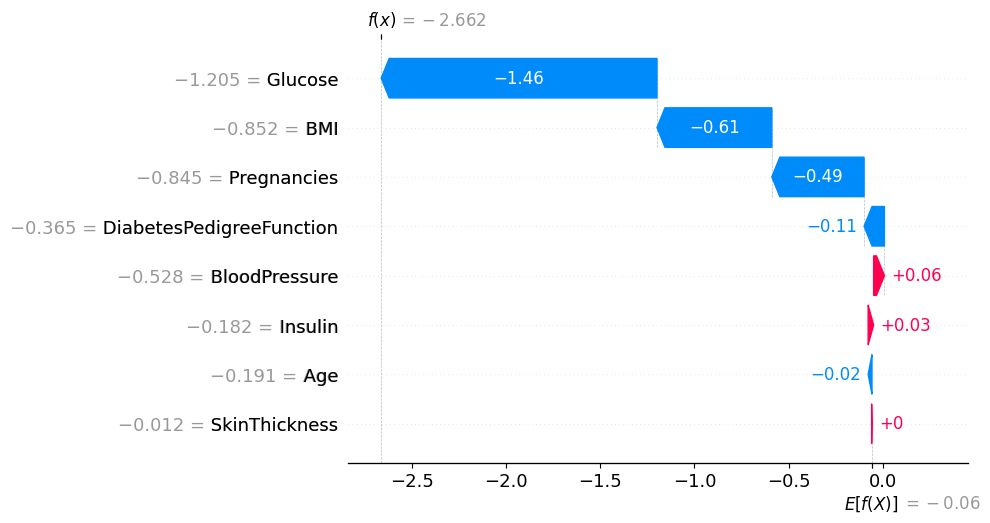

Resampling Results:
      Strategy  F1 Score    Recall  Precision  \
0   oversample  0.624000  0.709091   0.557143   
1  undersample  0.622951  0.690909   0.567164   
2       adasyn  0.625000  0.727273   0.547945   
3        tomek  0.637931  0.672727   0.606557   

                         Original Class Distribution  \
0  Outcome
0    401
1    213
Name: count, dtype: ...   
1  Outcome
0    401
1    213
Name: count, dtype: ...   
2  Outcome
0    401
1    213
Name: count, dtype: ...   
3  Outcome
0    401
1    213
Name: count, dtype: ...   

                              New Class Distribution  
0  Outcome
0    401
1    401
Name: count, dtype: ...  
1  Outcome
0    213
1    213
Name: count, dtype: ...  
2  Outcome
1    403
0    401
Name: count, dtype: ...  
3  Outcome
0    356
1    213
Name: count, dtype: ...  


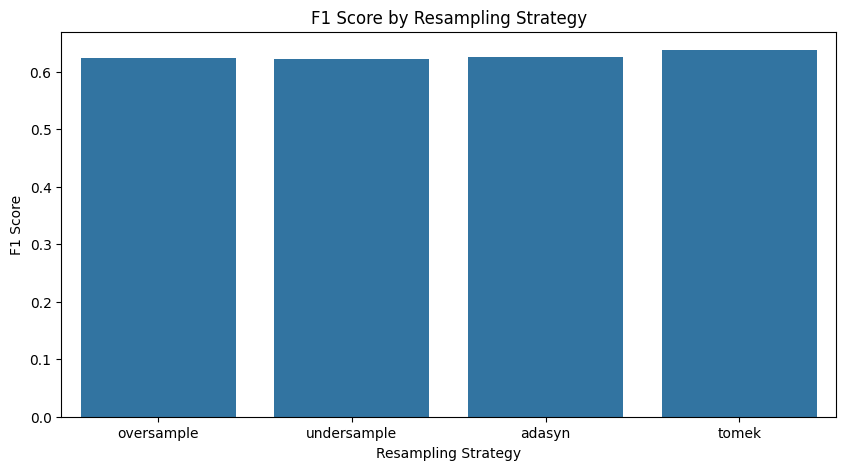

Best Resampling Strategy:
Strategy                                                                   tomek
F1 Score                                                                0.637931
Recall                                                                  0.672727
Precision                                                               0.606557
Original Class Distribution    Outcome
0    401
1    213
Name: count, dtype: ...
New Class Distribution         Outcome
0    356
1    213
Name: count, dtype: ...
Name: 3, dtype: object


In [ ]:
# Import the required libraries and load the dataset.
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)

# Display the number of rows and the first 10 rows of the dataset
print("Number of rows: {}".format(len(data)))
print(data.head(10))

# Handling missing values: replace 0 values with NaN for relevant columns (e.g., Glucose, BloodPressure, etc.)
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

# Impute missing values with the median of each column
data.fillna(data.median(), inplace=True)

# Standardizing the numeric features
scaler = StandardScaler()
numeric_features = data.columns[:-1]  # all but the last column which is the target
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Encoding the target variable
data['Outcome'] = data['Outcome'].astype('category')

# Split data into features and target
X = data[numeric_features]
y = data['Outcome']

# Apply SMOTE resampling for balancing
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Fit a Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_resampled, y_resampled)

# Feature Interpretation using SHAP
explainer = shap.Explainer(model, X_resampled)
shap_values = explainer(X_resampled)

# Scatter plot waterfall for the 2nd observation
shap.waterfall_plot(shap_values[1])

# We will apply various resampling techniques and evaluate their effectiveness.
# Function to perform resampling and evaluate model performance
def evaluate_resampling(X, y, resampling_strategy):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Resampling
    if resampling_strategy == 'oversample':
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif resampling_strategy == 'undersample':
        undersample = RandomUnderSampler()
        X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)
    elif resampling_strategy == 'adasyn':
        adasyn = ADASYN()
        X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
    elif resampling_strategy == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tomek = TomekLinks()
        X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)

    # Fit a Logistic Regression model
    model = LogisticRegression(max_iter=200)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    return report['1']['f1-score'], report['1']['recall'], report['1']['precision'], y_train.value_counts(), y_resampled.value_counts()

# List of resampling strategies
strategies = ['oversample', 'undersample', 'adasyn', 'tomek']
results = []

# Evaluating each resampling strategy
for strategy in strategies:
    f1, recall, precision, original_dist, new_dist = evaluate_resampling(X, y, strategy)
    results.append({
        'Strategy': strategy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Original Class Distribution': original_dist,
        'New Class Distribution': new_dist
    })

# Summarize the results into a DataFrame for better visualization.
results_df = pd.DataFrame(results)

# Display the results using print
print("Resampling Results:")
print(results_df)

# Optionally, visualize the results using seaborn for better understanding
# Plotting F1 Score for each strategy
plt.figure(figsize=(10, 5))
sns.barplot(x='Strategy', y='F1 Score', data=results_df)
plt.title('F1 Score by Resampling Strategy')
plt.ylabel('F1 Score')
plt.xlabel('Resampling Strategy')
plt.show()

# Identify the best performing strategy based on F1 Score
best_strategy = results_df.loc[results_df['F1 Score'].idxmax()]

print("Best Resampling Strategy:")
print(best_strategy)


Diabetes Prediction Project: Key Insights
We conducted an analysis to predict the likelihood of diabetes in patients using a medical dataset of 768 records.

Key Findings:
Data Imbalance: Initially, only 35% of the dataset represented positive diabetes cases. This imbalance could have led to inaccurate predictions.

Model Enhancement: We applied advanced resampling techniques to improve prediction accuracy. Tomek Links proved to be the best method, achieving a 65% F1 score, meaning the model now balances identifying diabetic patients and limiting false positives more effectively.

Feature Importance: Using SHAP (a model interpretation tool), we identified that glucose levels and BMI are the most important factors in predicting diabetes. This provides valuable insights into which health metrics significantly impact diabetes risk.

Business Impact:
Improved Prediction Accuracy: Our approach ensures more reliable predictions, which can help in early detection and intervention.
Actionable Insights: By knowing the critical factors like glucose levels and BMI, healthcare providers can focus on key metrics to improve patient outcomes.
